# Python: Difference-in-Differences

In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the average treatment effect on the treated under the conditional parallel trend assumption. The estimation is based on [Chang (2020)](https://academic.oup.com/ectj/article/23/2/177/5722119), [Sant'Anna and Zhao (2020)](https://www.sciencedirect.com/science/article/abs/pii/S0304407620301901) and [Zimmert et al. (2018)](https://arxiv.org/abs/1809.01643).

In this example, we will adapt the notation of [Sant'Anna and Zhao (2020)](https://www.sciencedirect.com/science/article/abs/pii/S0304407620301901).

In the whole example our treatment and time variable $t\in\{0,1\}$ will be binary. 
Let $D_i\in\{0,1\}$ denote the treatment status of unit $i$ at time $t=1$ (at time $t=0$ all units are not treated) and let $Y_{it}$ be the outcome of interest of unit $i$ at time $t$.
Using the potential outcome notation, the potential outcomes at 

## Panel Data (Repeated Outcomes)

At first, we will consider panel data of the following form.

Let 

## Repeated Cross-Sectional Data

In [80]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBClassifier, XGBRegressor

We will focus on the the Ddata generating processes from [Sant'Anna and Zhao (2020)](https://arxiv.org/abs/1812.01723), see Section 4.1 and 4.2.

In [58]:
def f_reg(W):
  res = 210 + 27.4*W[:, 0] + 13.7*(W[:, 1] + W[:, 2] + W[:, 3])
  return res

def f_ps(W):
  res = 0.75*(-W[:, 0] + 0.5*W[:, 1] - 0.25*W[:, 2] - 0.1*W[:, 3])
  return res

def dgp(n=200, dgp_type=1):
  # features
  X = np.random.normal(loc=0, scale=1, size=[n,4])
  Z_tilde_1 = np.exp(0.5*X[:, 0])
  Z_tilde_2 = 10 + X[:, 1] / (1 + np.exp(X[:, 0]))
  Z_tilde_3 = (0.6 + X[:, 0]*X[:, 2]/25)**3
  Z_tilde_4 = (20 + X[:, 1] + X[:, 3])**2

  Z_tilde = np.column_stack((Z_tilde_1, Z_tilde_2, Z_tilde_3, Z_tilde_4))
  Z = (Z_tilde - np.mean(Z_tilde, axis=0)) / np.std(Z_tilde, axis=0)
  
  # error terms
  epsilon_0 = np.random.normal(loc=0, scale=1, size=n)
  epsilon_1 = np.random.normal(loc=0, scale=1, size=[n,2])
  if dgp_type == 1:
    features_ps = Z
    features_reg = Z
  elif dgp_type == 2:
    features_ps = X
    features_reg = Z
  elif dgp_type == 3:
    features_ps = Z
    features_reg = X
  elif dgp_type == 4:
    features_ps = X
    features_reg = X
  elif dgp_type == 5:
    features_reg = Z
  elif dgp_type == 6:
    features_reg = X

  # treatment and propensities
  if (dgp_type == 5) or (dgp_type == 6):
    # Set D to be experimental
    p = 0.5*np.ones(n)
  else:
    p = np.exp(f_ps(features_ps)) / (1 + np.exp(f_ps(features_ps)))
  U = np.random.uniform(low=0, high=1, size=n)
  D = 1.0 * (p >= U)

  # potential outcomes
  nu =  np.random.normal(loc=D*f_reg(features_reg), scale=1, size=n)
  Y0 = f_reg(features_reg) + nu + epsilon_0
  Y1_d0 = 2*f_reg(features_reg) + nu + epsilon_1[:, 0]
  Y1_d1 = 2*f_reg(features_reg) + nu + epsilon_1[:, 1]
  Y1 = D*Y1_d1 + (1-D)*Y1_d0

  return Y0, Y1, D, Z, Y1_d0, Y1_d1


The ATT should be zero. We will check this numerically:

In [59]:
dgp_types = [1, 2, 3, 4, 5, 6]
n_dgps = len(dgp_types)

for dgp_type in dgp_types:  
    _, _, D, _, Y1_d0, Y1_d1 = dgp(int(10e+6), dgp_type=dgp_type)
    ATT = np.mean(Y1_d1[D == 1] - Y1_d0[D == 1])
    print(f'ATT (DGP={dgp_type}): {ATT}')
# Set the true ATT to zero
ATT = 0

ATT (DGP=1): 0.00017714460408496785
ATT (DGP=2): -7.786579431018051e-05
ATT (DGP=3): -0.00037106941603644387
ATT (DGP=4): -0.0002544412554790141
ATT (DGP=5): 0.0006732709733100862
ATT (DGP=6): -0.0008134639869466084


In [60]:
np.random.seed(42)
n_rep = 200
n_obs = 1000
lambda_T = 0.5

datasets = []
for dgp_type in dgp_types:
    datasets_dgp = []
    for i in range(n_rep):
        Y0, Y1, D, X, _, _ = dgp(n=n_obs, dgp_type=dgp_type)

        # datasets with Y_delta as outcome
        Y_delta = Y1 - Y0
        data = dml.DoubleMLData.from_arrays(X, Y_delta, D)
        datasets_dgp.append(data)
    datasets.append(datasets_dgp)

In [61]:
n_estimators = 50

# Random Forest
# ml_g = RandomForestRegressor(n_estimators=n_estimators)
# ml_m = RandomForestClassifier(n_estimators=n_estimators)

# Boosted Trees
ml_g = XGBRegressor(n_jobs=1, objective = "reg:squarederror",
                    eta=0.1, n_estimators=n_estimators)
ml_m = XGBClassifier(n_jobs=1, objective = "binary:logistic",
                     eval_metric = "logloss",
                     eta=0.1, n_estimators=n_estimators)

# linear models
#ml_g = LinearRegression()
#ml_m = LogisticRegression()

n_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {n_cores}")
# to be process folds in parallel
cores_used = 5

Number of Cores: 8


## Repeated Cross-sectional Data

Use the same data with coss-sectional observations

In [62]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [63]:
score_names = ["Not Experimental", "Experimental"]
valid_scores = ['PA-1', 'PA-2']
n_scores = len(valid_scores)
coefs = np.full((n_rep, n_dgps, n_scores), np.nan)
ses = np.full((n_rep, n_dgps, n_scores), np.nan)
cover = np.full((n_rep, n_dgps, n_scores), np.nan)
ci_length = np.full((n_rep, n_dgps, n_scores), np.nan)

for i_dgp, dgp_type in enumerate(dgp_types):
    print(f'DPG={dgp_type}')
    for i_rep in range(n_rep):
        if (i_rep % int(n_rep/10)) == 0:
            print(f'Iteration: {i_rep}/{n_rep}')
        obj_dml_data = datasets[i_dgp][i_rep]
        with suppress_stdout():
            for i_score, score in enumerate(valid_scores):
                dml_DiD = dml.DoubleMLDID(obj_dml_data,
                                          ml_g=clone(ml_g),
                                          ml_m=clone(ml_m),
                                          score=score,
                                          n_folds=5)
                dml_DiD.fit(n_jobs_cv=cores_used)
                # save coefs and ses
                coefs[i_rep, i_dgp, i_score] = dml_DiD.coef
                ses[i_rep, i_dgp, i_score] = dml_DiD.se

                # calculate confidence interval
                confint = dml_DiD.confint(level=0.95)
                cover[i_rep, i_dgp, i_score] = (confint['2.5 %'] < ATT) & (ATT < confint['97.5 %'])
                ci_length[i_rep, i_dgp, i_score] = confint['97.5 %'] - confint['2.5 %']

print('Finished!')

DPG=1
Iteration: 0/200
Iteration: 20/200
Iteration: 40/200
Iteration: 60/200
Iteration: 80/200
Iteration: 100/200
Iteration: 120/200
Iteration: 140/200
Iteration: 160/200
Iteration: 180/200
DPG=2
Iteration: 0/200
Iteration: 20/200
Iteration: 40/200
Iteration: 60/200
Iteration: 80/200
Iteration: 100/200
Iteration: 120/200
Iteration: 140/200
Iteration: 160/200
Iteration: 180/200
DPG=3
Iteration: 0/200
Iteration: 20/200
Iteration: 40/200
Iteration: 60/200
Iteration: 80/200
Iteration: 100/200
Iteration: 120/200
Iteration: 140/200
Iteration: 160/200
Iteration: 180/200
DPG=4
Iteration: 0/200
Iteration: 20/200
Iteration: 40/200
Iteration: 60/200
Iteration: 80/200
Iteration: 100/200
Iteration: 120/200
Iteration: 140/200
Iteration: 160/200
Iteration: 180/200
DPG=5
Iteration: 0/200
Iteration: 20/200
Iteration: 40/200
Iteration: 60/200
Iteration: 80/200
Iteration: 100/200
Iteration: 120/200
Iteration: 140/200
Iteration: 160/200
Iteration: 180/200
DPG=6
Iteration: 0/200
Iteration: 20/200
Iteration

## Results

In [64]:
dpg_summary = []
for i_dgp, dgp_type in enumerate(dgp_types):
    data = {'Avg. Bias': coefs[:, i_dgp, :].mean(0),
            'RMSE': np.sqrt(np.square(coefs[:, i_dgp, :])).mean(0),
            'Asy. Variance': np.sqrt(n_obs)*np.square(ses[:, i_dgp, :]).mean(0),
            'Coverage': cover[:, i_dgp, :].mean(0),
            'Avg. CI length': ci_length[:, i_dgp, :].mean(0)}
    dpg_summary.append(pd.DataFrame(data, index=score_names))
print("Summary DGP=1")
dpg_summary[0]

Summary DGP=1


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Not Experimental,-0.174415,0.948425,58.252326,1.00,5.065623
Experimental,-2.432090,2.432090,12.614557,0.04,2.463736


In [65]:
print("Summary DGP=2")
dpg_summary[1]

Summary DGP=2


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Not Experimental,-0.417534,1.374452,110.272581,0.980,6.727293
Experimental,-1.389002,1.404732,11.404659,0.385,2.343931


In [66]:
print("Summary DGP=3")
dpg_summary[2]

Summary DGP=3


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Not Experimental,-0.417066,1.017914,68.741066,0.965,5.548693
Experimental,-1.053731,1.090447,11.780155,0.565,2.391088


In [67]:
print("Summary DGP=4")
dpg_summary[3]

Summary DGP=4


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Not Experimental,-0.199835,1.093100,97.049449,0.975,6.539464
Experimental,-2.300266,2.300266,11.428790,0.040,2.355399


In [68]:
print("Summary DGP=5")
dpg_summary[4]

Summary DGP=5


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Not Experimental,-0.504128,0.787918,33.938490,0.965,3.878076
Experimental,0.037399,0.461257,9.443674,0.935,2.131685


In [69]:
print("Summary DGP=6")
dpg_summary[5]

Summary DGP=6


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Not Experimental,-0.335531,0.764008,30.479523,0.965,3.787889
Experimental,0.071205,0.466371,11.081003,0.955,2.319064


In [89]:
df_plot_dens = pd.DataFrame(data=None, columns=['DGP', 'Algorithm', 'ATT'])
df_plot_cov = pd.DataFrame(data=None, columns=['DGP', 'Algorithm', 'Coverage'])
for i_dgp, dgp_type in enumerate(dgp_types):
    for i_score, score in enumerate(score_names):
        # add ATT estimates for density plot
        df = pd.DataFrame(coefs[:, i_dgp, i_score], columns=['ATT'])
        df['DGP'] = str(dgp_type)
        df['Algorithm'] = score
        df_plot_dens = pd.concat([df_plot_dens, df], axis=0)

        #add coverage data
        df = pd.DataFrame(np.array([[cover[:, i_dgp, i_score].mean()]]), columns=["Coverage"])
        df['DGP'] = str(dgp_type)
        df['Algorithm'] = score
        df_plot_cov = pd.concat([df_plot_cov, df], axis=0)

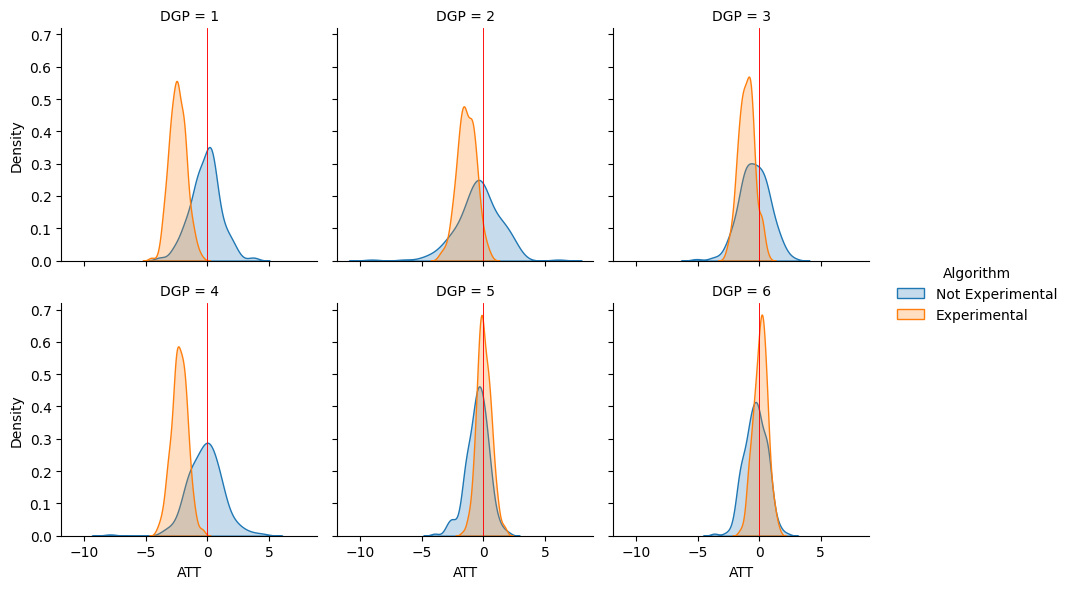

In [90]:
g = sns.FacetGrid(df_plot_dens, col="DGP", hue="Algorithm", col_wrap=3)
g.map_dataframe(sns.kdeplot, x="ATT", fill=True)
g.add_legend()
g.map(plt.axvline, x=ATT, ls='-', c='red', lw=0.5)

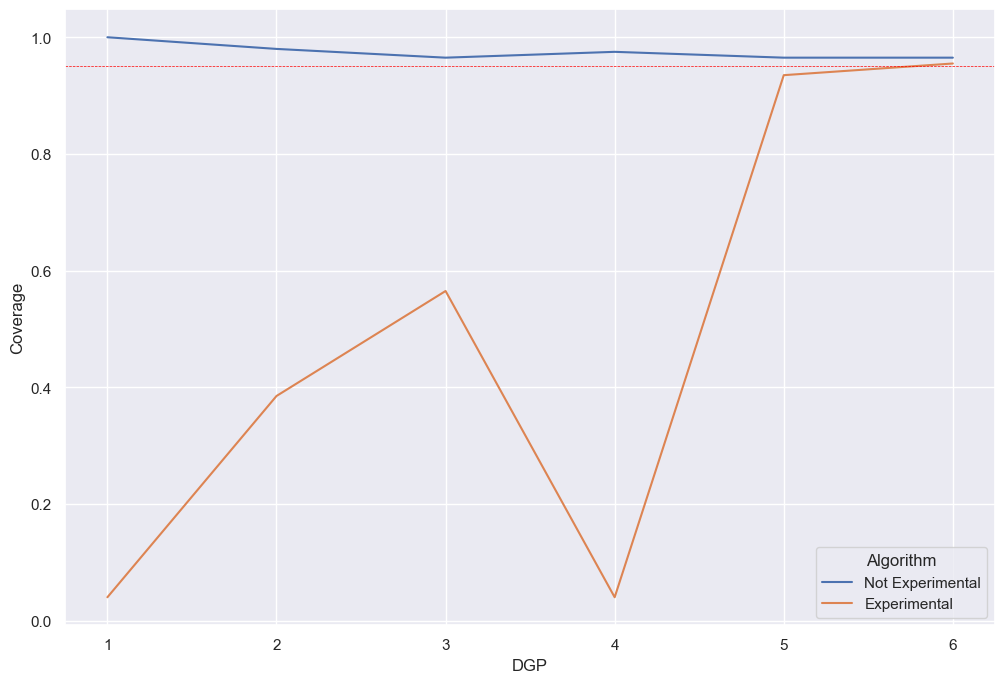

In [91]:
sns.set(rc={'figure.figsize':(12,8)})
g = sns.lineplot(data=df_plot_cov, x="DGP", y="Coverage", hue="Algorithm")
g.axhline(0.95, ls='--', c='red', lw=0.5)